# Temperature Tutorial

In [1]:
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
import pandas as pd
import gdal
import os
import datetime
from datetime import timedelta
import numpy as np
import fiona
import shapely
from shapely import geometry
from os.path import dirname
import glob
import seaborn
import sys
import pickle
from functools import partial

parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','4_temperature'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))
from temperature import SimpleTemperature
from channel import SimpleChannel
import zonal_stats as zs
import meteolib as meteo
import evaplib as evap

/Users/daviddralle/anaconda2/envs/py2k_gis/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
try:
    basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
except RuntimeError:
    print 'Cannot find basins shapefile. Please make sure basins shapefile is located in \n the model directory under /raw_data/basins_poly'

In [3]:
fc = fiona.open(basins)
shapefile_record = fc.next()
pos_dict={}
for shapefile_record in fc:
    shape = shapely.geometry.asShape(shapefile_record['geometry'])
    long_point = shape.centroid.coords.xy[0][0]
    lat_point = shape.centroid.coords.xy[1][0]
    pos = (long_point, lat_point)
    pos_dict[int(shapefile_record['properties']['cat'])]=pos

In [4]:
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
climate_group_forcing = pickle.load( open( os.path.join(parent_dir,'model_data','climate_group_forcing.p'), "rb" ) )
model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))
temperature_params = pickle.load( open( os.path.join(parent_dir, 'model_data', 'temperature_params.p'), 'rb'))
hill_groups = pickle.load( open( os.path.join(parent_dir,'model_data','solved_hillslope_discharge.p'), "rb" ) )
solved_channel_routing = pickle.load( open( os.path.join(parent_dir,'model_data','solved_channel_routing.p'), "rb" ) )
channel_params = pickle.load( open( os.path.join(parent_dir,'model_data','channel_params.p'), "rb" ))

#start/stop dates for running model  
#spinup date is the date after start_date for which we assume model is finished spinning up         
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = model_config['dt_temperature']
t = model_config['t_temperature']
resample_freq_channel = model_config['resample_freq_channel']
resample_freq_hillslope = model_config['resample_freq_hillslope']
resample_freq_temperature = model_config['resample_freq_temperature']
timestamps_hillslope = model_config['timestamps_hillslope']
timestamps_channel = model_config['timestamps_channel']
timestamps_temperature = model_config['timestamps_temperature']


temperature_network = {}
for rew_id in rew_config.keys(): 
    args = rew_config[rew_id].copy()
    args.update(temperature_params[rew_id])
    temperature_network[rew_id] = args['model'](rew_id=rew_id, **args)
    
channel_network = {}
for rew_id in rew_config.keys(): 
    args = rew_config[rew_id].copy()
    args.update(channel_params[rew_id])
    channel_network[rew_id] = args['model'](rew_id=rew_id, **args)


In [5]:
#For now, set all LPI to 0.2
LPI = 0.01
rew_ids = rew_config.keys()
shreves = [rew_config[rew_id]['shreve'] for rew_id in rew_ids]
rewQueue = [rew_id for (shreve,rew_id) in sorted(zip(shreves,rew_ids))]
network_temps = {}
print "Solve REWs in this order:"
print(rewQueue)

for rew_id in rewQueue:
    
    print 'Working on REW ' + str(rew_id)
    shreve  = rew_config[rew_id]['shreve']
    group_id = rew_config[rew_id]['group']
    climate_group_id = group_id[1]
    rew_df = climate_group_forcing[climate_group_id]
    
    #Calculate longwave incoming radiation using Konzelmann et al. 1994
    #Use PRISM daily min/max temperature to generate temp time series
    #for each REW, load the same shortwave radiation dataset from Angelo sensor database
    #TODO: THIS CODE NEEDS TO BE MADE MORE GENERAL. For the moment, we are using
    #point data for shortwave. 
    rng = pd.date_range(start_date,datetime.datetime(stop_date.year,stop_date.month, stop_date.day, 12, 0),freq='12H')
    interleaved = [val for pair in zip(rew_df['tmin'][start_date:stop_date], rew_df['tmax'][start_date:stop_date]) for val in pair]
    minmax = pd.DataFrame(interleaved, index=rng, columns=['ta']).reindex(index=timestamps_temperature,fill_value=np.nan).interpolate(method='linear')
    ea = rew_df['ea'].reindex(index=timestamps_temperature,fill_value=np.nan).interpolate(method='linear')
    temp_ea = pd.concat([minmax, ea],axis=1)
    sigma = 5.67e-8 #(watts)/(m^2 K^4)
    F = 1 #cloud fraction, here taken to be 1
    epscs = 0.23 + 0.4393*(1000*temp_ea['ea']/(temp_ea['ta']+273.16))**(1/7.0)
    Lin = epscs*F*sigma*(temp_ea['ta']+273.16)**4
    Lin = np.array(Lin[start_date:stop_date])
    Sin = pickle.load( open( os.path.join(parent_dir, 'raw_data','shortwave','shortwave.p'), 'rb')).reindex(index=timestamps_temperature,fill_value=np.nan).interpolate(method='linear')
    Sin = np.array(Sin[start_date:stop_date])
    
    # Get other forcing data, re-sample to current timestamps
    # everything converted to meters/seconds/kelvin/kg
    ppt = 1.15741e-7*np.array(climate_group_forcing[climate_group_id][start_date:stop_date].ppt.resample(resample_freq_temperature).ffill())
    Ta = np.array(temp_ea['ta'][start_date:stop_date])
    hillslope_discharge = pd.DataFrame({'discharge':hill_groups[group_id]['discharge']}, index=hill_groups[group_id].index)
    hillslope_volumetric_discharge = 1.15741e-11*np.array(hillslope_discharge[start_date:stop_date].discharge.resample(resample_freq_temperature).ffill())*rew_config[rew_id]['area_sqcm']
    volumes = 1e-6*np.array(solved_channel_routing[rew_id][start_date:stop_date].volumes.resample(resample_freq_temperature).ffill())
    volumetric_discharge = 1.15741e-11*np.array(solved_channel_routing[rew_id][start_date:stop_date].volumetric_discharge.resample(resample_freq_temperature).ffill())
    width = 0.01*channel_network[rew_id].width
    length = 0.01*channel_network[rew_id].length

    temp = np.zeros(np.shape(t))
    
     #get upstream discharges, upstream temperatures
    if shreve == 1:
        vol_1 = np.zeros(np.shape(t))
        vol_2 = np.zeros(np.shape(t))

        temp_1 = np.zeros(np.shape(t))
        temp_2 = np.zeros(np.shape(t))
    else:
        upstream_1 = rew_config[rew_id]['prev_str01']
        upstream_2 = rew_config[rew_id]['prev_str02']

        vol_1 = 1.15741e-11*np.array(solved_channel_routing[upstream_1][start_date:stop_date].volumetric_discharge.resample(resample_freq_temperature).ffill())
        vol_2 = 1.15741e-11*np.array(solved_channel_routing[upstream_2][start_date:stop_date].volumetric_discharge.resample(resample_freq_temperature).ffill())

        temp_1 = np.array(network_temps[upstream_1].reindex(index=timestamps_temperature,fill_value=np.nan).interpolate(method='linear'))
        temp_2 = np.array(network_temps[upstream_2].reindex(index=timestamps_temperature,fill_value=np.nan).interpolate(method='linear'))

    for i in range(300000,len(t)):
        temperature_network[rew_id].update(dt, vol_1[i], temp_1[i], vol_2[i], temp_2[i], hillslope_volumetric_discharge[i], volumetric_discharge[i], width, length, volumes[i], Ta[i], Lin[i], Sin[i], ppt[i], LPI)
        temp[i]=temperature_network[rew_id].temperature

    network_temps[rew_id] = pd.DataFrame(temp,index=timestamps_temperature,columns=['temperature'])

Solve REWs in this order:
[1, 2, 4]
Working on REW 1
Working on REW 2
Working on REW 4


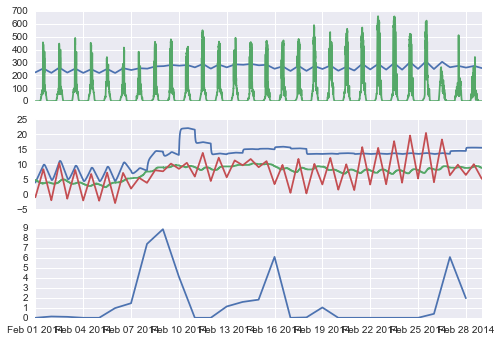

In [72]:
temp_data = pd.read_csv(os.path.join(parent_dir, 'elder_temps.txt'), sep='\t', header=27)
temp_data.columns = ['us','gage','date','pdf','temp','a']
rng = pd.to_datetime(temp_data.date)
temp_data.index = rng

Lin = epscs*F*sigma*(temp_ea['ta']+273.16)**4
ppt = climate_group_forcing[climate_group_id][start_date:stop_date].ppt
shortwave = pickle.load( open( os.path.join(parent_dir, 'raw_data','shortwave','shortwave.p'), 'rb')).reindex(index=timestamps_temperature,fill_value=np.nan).interpolate(method='linear')
f, (ax1, ax2, ax3) = plt.subplots(3,sharex=True)
ax1.plot(Lin.loc['2-2014'])
ax1.plot(shortwave.loc['2-2014'])
ax2.plot(network_temps[4].loc['2-2014'])
ax2.plot(temp_data.temp.loc['2-2014'])
ax3.plot(ppt.loc['2-2014'])
ax2.plot(temp_ea.ta.loc['2-2014'])


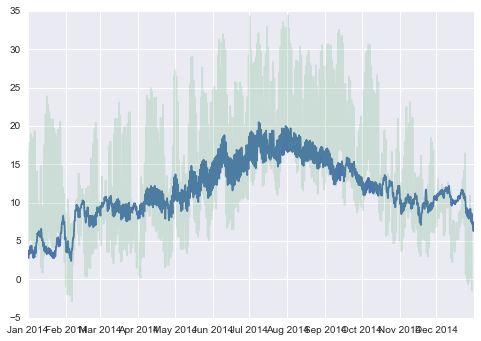

In [79]:
plt.plot(temp_data.temp.loc['2014'])
plt.plot(temp_ea.ta.loc['2014'],alpha=.2)

# temp_data = pd.DataFrame(temp_data['temp'], index=rng, columns=['temp'])

In [32]:
len(hillslope_volumetric_discharge)

1313281